# What can affect how you rate a beer?

When we taste a beer and rate it we might think that our rating is based solely on how much we liked or disliked the beer. <br> However what we might not realize is that we may not be completely rational when it comes to our most liked or disliked beers/breweries, and we might rate them the way we do because of underlying intrinsic and extrinsic factors that we are not consciously aware of.
For instance you might really like Pale Ale because it was the first beer you tried in college in the US, but maybe if you had went to college in Germany your palate would've been more accustomed to Lager and you would've rated it better than Pale Ale style beers.<br>
With this project we wanted to dig deeper into the ratings and reviews given by users to highlight factors that might create a conscious or subconscious bias to how you rate a beer. However the list of such biases is unlimited, so we decided to focus on 3 main biases that could affect how you construct your opinion and explored how they do so. To us, those were some of the most important ones that could be done given the data we have. <br>
So without further ado, here's a data exploration of how your senses, location and political events you country might've witnessed can shape the way you rate a beer.

We are interested in the factors that define how much we like a beer. <br>
The goal is to investigate how important are intrinsic and extrinsic factors. <br>
For the intrinsic features we can make use of the ratings of different sensory aspects. <br>
For extrinsic influences it was a bit more difficult. We decided to look at the proximity to the brewery. <br>
Possibly a local beer could trigger a feeling of pride or affiliation, leading to a higher opinion. <br>

As another external factor we try to investigate economic factors. <br>
To do that we take a closer look at the financial crisis in 2007/2008.

## Table of Contents
- [Imports and paths](#imports)
- [Data extraction](#dataextraction)
    - [BeerAdvocate data](#beeradvocate)
    - [RateBeer data](#ratebeer)
    - [Matched data](#matched_data)
- [Data description](#datadescription)
    - [Beers](#beer_data)
    - [Breweries](#brewery_data)
    - [Users](#users)
    - [Reviews](#reviews)
- [Data pre-processing](#data_preprocessing)
    - [Users](#users_processing)
    - [Breweries](#breweries_processing)
    - [Reviews](reviews_processing)
- [Data exploration](#data_exploration)
- [Sensorial evaluation](#sensory)
- [Location bias](#location)
- [Political/Economic climate effect](#political)
- [Chapter 3](#chapter_3)
    - [Section 3.1](#section_3_1)
        - [Sub Section 3.1.1](#sub_section_3_1_1)
        - [Sub Section 3.1.2](#sub_section_3_1_2)
    - [Section 3.2](#section_3_2)
        - [Sub Section 3.2.1](#sub_section_3_2_1)
        - [Sub Section 3.2.2](#sub_section_3_2_2)

## Imports and paths<a class="anchor" id="imports"></a>

In [94]:
#reading data
import gzip #to read gzip files

#manipulating data 
import pandas as pd
import numpy as np
import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#serializing data
import pickle

#statistics
from scipy.stats import linregress

#for machine learning algorithms 
import torch

#for math manipulations
import math

#set the seed for reproducibility 
np.random.seed(4)

In [4]:
PATH = '../'
DATA_PATH = './data/' 
DEFAULT_ENCODING = 'UTF8'
DEFAULT_COMPRESSION = 'gzip'

## Data extraction <a class="anchor" id="dataextraction"></a>

We start by extracting the data for beers, breweries and users from the two rating websites BeerAdvocate and RateBeer as well as the matched data. <br>
We view the dataframe first few rows to get a firt glance at what the data contains before pre-processing it:

### BeerAdvocate data <a class="anchor" id="beeradvocate"></a>

In [3]:
BA_beers = pd.read_csv(PATH+'BeerAdvocate/beers.csv', index_col='beer_id')
BA_beers.head(1)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN


In [4]:
BA_breweries = pd.read_csv(PATH+'BeerAdvocate/breweries.csv', index_col='id')
BA_breweries.head(1)

,location,name,nbr_beers
id,,,
39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5


In [5]:
BA_users = pd.read_csv(PATH+'BeerAdvocate/users.csv', index_col= 'user_id')
BA_users.head(1)

,nbr_ratings,nbr_reviews,user_name,joined,location
user_id,,,,,
nmann08.184925,7820,465,nmann08,1.199704e+09,"United States, Washington"


As for the BeerAdvocate text reviews, the text files were in a quite special format, we extracted them in the notebook 'TransformTextfileToCsv.ipynb' ([here](TransformTextfileToCsv.ipynb)) and saved them into csv files which we load below to take a look at: 

In [4]:
#open the csv file
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",Gabon,Gabon,"United States, Washington",United States


### RateBeer data <a class="anchor" id="ratebeer"></a>

In [7]:
RB_beers = pd.read_csv(PATH+'RateBeer/beers.csv', index_col='beer_id')
RB_beers.head(1)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,
410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.0,NaN,0,NaN


In [8]:
RB_breweries = pd.read_csv(PATH+'RateBeer/breweries.csv', index_col= 'id')
RB_breweries.head(1)


,location,name,nbr_beers
id,,,
3198,Gabon,Sobraga,3


In [9]:
RB_users = pd.read_csv(PATH+'RateBeer/users.csv', index_col= 'user_id')
RB_users.head(1)

,nbr_ratings,user_name,joined,location
user_id,,,,
175852,1890,Manslow,1.337508e+09,Poland


For the RateBeer text reviews, the text files were in a quite special format, we extracted them in the notebook 'TransformTextfileToCsv.ipynb' ([here](TransformTextfileToCsv.ipynb)) and saved them into csv files:

In [29]:
#open the csv file
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",Gabon,Gabon,Poland,Poland


### Matched data <a class="anchor" id="matched_data"></a>

In [23]:
matched_beers = pd.read_csv(PATH+'matched_beer_data/beers.csv', header=1)
matched_beers.head(1)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.0,1.0


In [24]:
matched_breweries = pd.read_csv(PATH+'matched_beer_data/breweries.csv', header=1)
matched_breweries.head(1)

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062


In [33]:
matched_users = pd.read_csv(PATH+'matched_beer_data/users.csv', header=1)
matched_users.head(1)

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,1.220868e+09,Germany,6,6,erzengel.248045,Erzengel,erzengel,1.224324e+09,Germany,8781,83106,Erzengel,erzengel


In [40]:
matched_ratings = pd.read_csv(PATH+'matched_beer_data/ratings.csv', encoding = "ISO-8859-1", header=1)
matched_ratings.head(1)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃÂ¼ÃÂ. Riecht sc...,83106,Erzengel


## Data description  <a class="anchor" id="datadescription"></a>

### Beers  <a class="anchor" id="beer_data"></a>

Both rating websites contain similar structures for the beer datasets

The variables in the BeerAdvocate beer data are:
- *beer_id*(we set it as index) and *beer_name* : the id and name of the beer (which are also used in the reviews)
- *brewery_id* : the id of the brewery (which is also used in the reviews)
- *nbr_ratings* and *nbr_reviews*: the number of ratings and reviews a beer received
- *avg* : the average rating of a beer (from 0 and 5)
- *ba_score* : the beer's overall score based on its ranking within its style category. It's based on the beer's truncated (trimmed) mean and a custom Bayesian (weighted rank) formula that takes the beer's style into consideration. Its purpose is to provide consumers with a quick reference using a format that's familiar to the wine and liquor worlds.<br> 
The score is out of 100 with the following range: <br>
95-100 = world-class <br>
90-94 = outstanding <br>
85-89 = very good <br>
80-84 = good <br>
70-79 = okay <br>
60-69 = poor <br>
< 60 = awful <br>
- *bros_score* : the score given by the two brothers running the BeerAdvocate website
- *abv* : is the alcohol content of the beer (%)
- *avg_computed* : 
- *zscore* : 
- *nbr_matched_valid_ratings* : 
- *avg_matched_valid_ratings* : <br>
reference [here](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/)

The RateBeer beer dataframe contains all the variables listed above except for the *nbr_reviews*, *ba_score* and *bros_score* (which makes sense). Instead the Ratebeer website has three different scores: <br>
- *overall_score* : a score that reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer. (out of 100)
- *style_score* : a score that ranks this beer against all beers within its own style category.
<br>
Those two scores are calculated only from ratings that are accompanied with a written review of 75 or more characters. A rating doesn't count toward the final rating if the rater has left fewer than 10 ratings, if it is is deemed unauthentic, derogatory or abusive or if the rating was made by a brewer or brewer affiliate. <br>
reference [here](https://www.ratebeer.com/our-scores)

###DESCRIBE MATCHED DATA<br>
We have a dataset available with matched datapoints. <br>
This is useful if we want to look at a certain effect and compare it in both rating websites. <br>
The matching was done in a project that investigated the herding effect. In particular how the first rating influences the final score of the beer. <br>
The rationale behind matching is to avoid biases due to difference in the two populations. For example could individuals of one group be more wealthy, which would introduce the hidden variable "income". <br>
Therefore, the propensity score was introduced. It uses the available features to predict the outcome variable y, for example via regression. <br>
In the matched dataset we have pairs of individuals from both groups, with the most similar scores. <br>
This minimizes the risk for hidden variables and insures that we have the same number of individuals from both groups.<br>
The latter is important to avoid higher weighting of one group due to overrepresentation.

For our project the matched dataset is not interesting, as we investigate global effects where comparison inside the group is not required.

### Breweries  <a class="anchor" id="brewery_data"></a>

On both rating websites the breweries data contain the same variables: 
- *id* (set as index) : the brewery's id which corresponds ot the id *brewery_id* from the beer dataset
- *location* : the location of the brewery
- *name* : the name of the brewery
- *nbr_beers* : the number of beers that brewery produces

##DESCRIBE MATCHED BREWERIES

### Users  <a class="anchor" id="users"></a>

On both rating websites the user data contains the same variables (except for *nbr_reviews* which is unique to BeerAdvocate):
- *user_id* (set as index) : the user_id 
- *nbr_ratings* : the number of ratings the reviewer has put on the website
- *nbr_reviews* (unique to BeerAdvocate) : the number of reviews a user has given on the website
- *user_name* : the username
- *joined* : the date when the user joined the websites
- *location* : the user's location

#DESCRIBE MATCHED USERS

### Reviews  <a class="anchor" id="reviews"></a>

From both websites the reviews have the same structure, they contain the following elements:
- *beer_name* and *beer_id* : the beer name abd id of the corresponding beer in the beer dataset
- *brewery_name* and *brewery_id* : the brewery name and id of the corresponding brewery in the brewery dataset
- *style* : corresponds to one out of 104 (BeerAdvocate) or 93 (RateBeer) different beer styles
- *abv* : the alcohol content of the beer (%)
- *date* : the date of the review
- *user_name* and *user_id* : the username and the id of the reviewer (which correspond to the ones in user)
- *text* : the text review

For the rating itself both websites do similar things: the user's beer rating is comprised of five relatable attributes (represented as features in the dataframe): *appearance*, *aroma*, *palate*, *taste* and *overall* which contribute to the final *rating*. But they are slightly different:

* BeerAdvocate:
each of the five attributes is given a point value on a 1–5 point scale with 0.25 increments, and then the final user rating is calculated using BeerAvocate's weighted rating system, wherein certain attributes are applied with more importance (The weights for each of the attributes are the following: 6% for appearance, 24% for the smell, 10% for palate and 40% for the taste). reference [here](https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/)

* RateBeer:
Appearance and Mouthfeel are each scored out of 5. Aroma and Taste are scored out of 10. While Overall is scored out of 20. These all combine to give the beer a total score out of 50, which is then divided and displayed as a score out of 5 for each rating. reference [here](https://www.ratebeer.com/our-scores).

## Data pre-processing  <a class="anchor" id="data_preprocessing"></a>

The data preprocessing done allows the generation of three dataframes *df_BA_reviews* *df_RB_reviews* and *df_reviews_all* which contain the processed review dataframes from both websites and df_reviews_all contains both dataframes concatenated.
We save these dataframes into a folder called DataFrameStorage as these computations are extremely long. 
This data pre-processing was thus ran once and in the following notebook [here](DataPreprocessing.ipynb) we just read the dataframes from the folder.

The data pre-processing consists of the following:

*Users* <br>
For both rating websites :
- We convert the *joined* column from seconds into a datetime object 
- Nan locations are changed to 'Unknown'
- We add a column called *merged_location* where all the states of the United States are just defined as United States (this will be useful for analyses where we only care about comparing countries)
For the matched data we just convert the *joined* to a datatime object as we will use primarly the two other dataframes when it comes to analyzing locations.

*Breweries* <br>
- Nan locations are changed to 'Unknown'
- Same as for the beers: we add a column called *merged_location* where all the states of the United States are just defined as United States (this will be useful for analyses where we only care about comparing countries)

*Reviews* <br>

- Nan locations are changed to 'Unknown'
- The column of the review date *date* is converted from seconds to datetime object

For both rating websites we added 4 columns to the review dataframes (by using the breweries and users dataframes) : 
- brewery_location : contains the brewery's location (same as in raw data: we have the detail of each state in the United States)
- brewery_merged_location : contains the brewery's location with all states of United States simply named United states (for comparing countries)
- user_location :  contains the user's location (same as in raw data: we have the detail of each state in the United States)
- user_merged_location :  contains the user's location with all states of United States simply named United states (for comparing countries)

We also created a *df_reviews_all* which essentially contains all the reviews concatenated along columns.


## Data exploration  <a class="anchor" id="data_exploration"></a>

We have our review dataframes stored in DataframeStorage, so we just start by reading those below (in different cells because this is computationally expensive). Note that we have to re-convert the *date* columns to datetime objects as this is lost in the preprocessing once we converr them to csv (saved as strings):

In [5]:
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [6]:
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [7]:
df_reviews_all = pd.read_csv(PATH+'/DataframeStorage/df_reviews_all.csv')
df_reviews_all['date'] = pd.to_datetime(df_reviews_all['date'], format="%Y-%m-%d %H:%M:%S")

FileNotFoundError: [Errno 2] No such file or directory: '..//DataframeStorage/df_reviews_all.csv'

```
HERE WE CAN INCLUDE A FEW NUMBERS AND PLOTS RELEVANT TO OUR STORY

```

Now let's take a closer look at the reviews data:

### Location of users reviewing beers

We first plot the counts of users per location. **Note that the y axis is logarithmic so it represents orders of magnitude.**

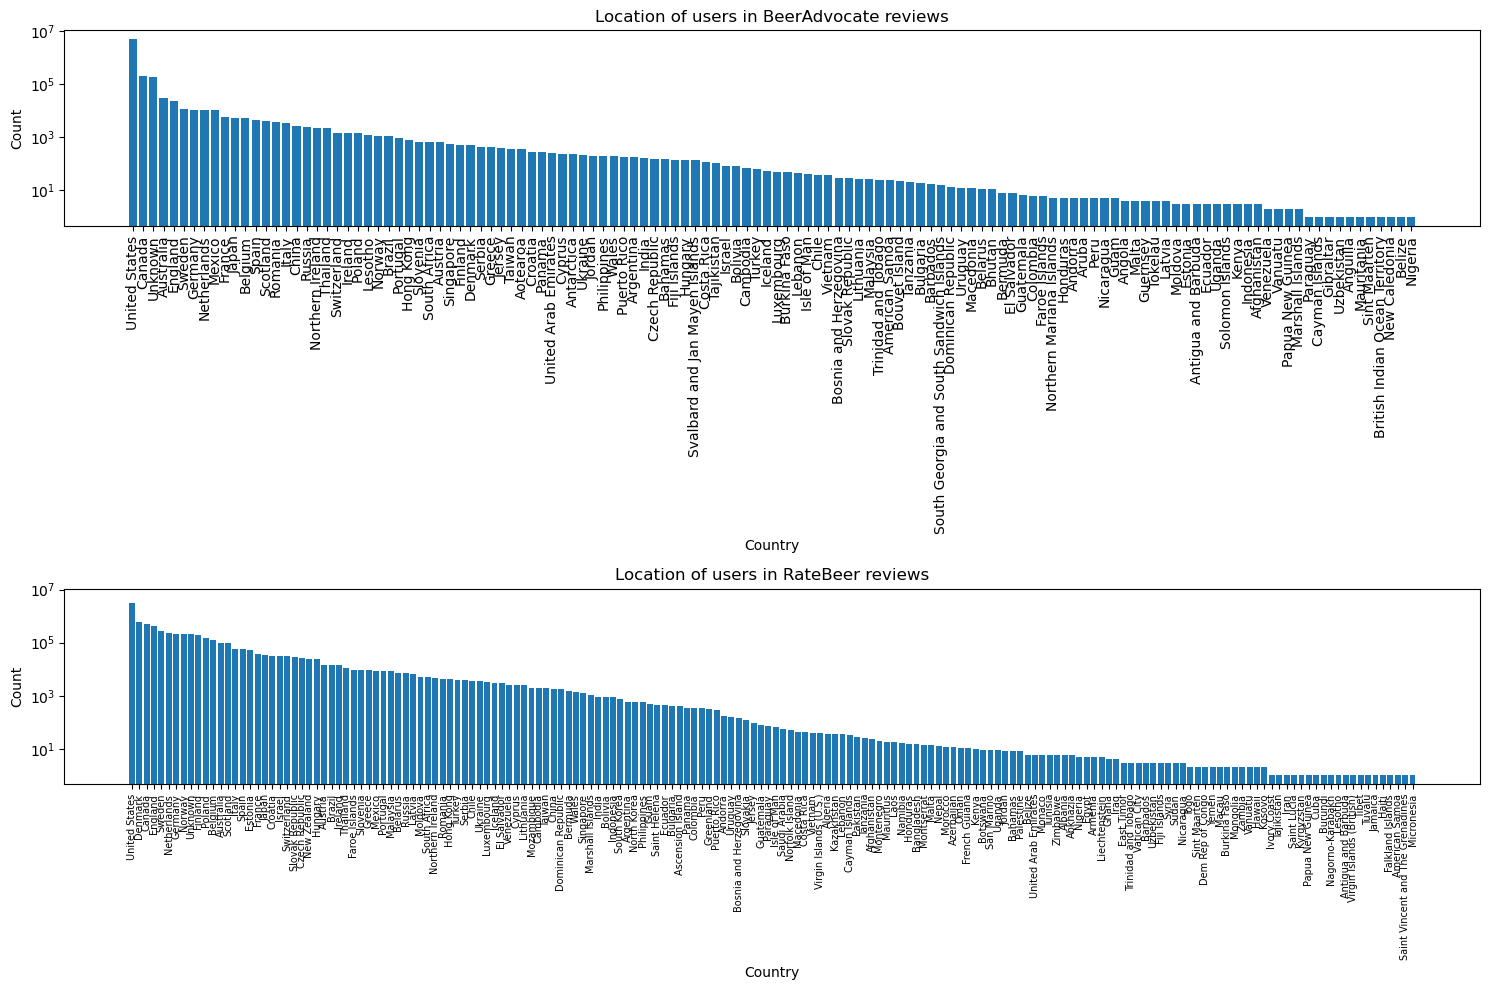

In [56]:
BA_counts_countries_beers = pd.DataFrame(df_BA_reviews['user_merged_location'].value_counts())
BA_counts_countries_beers.reset_index(inplace=True)

RB_counts_countries_beers = pd.DataFrame(df_RB_reviews['user_merged_location'].value_counts())
RB_counts_countries_beers.reset_index(inplace=True)

fig, axes = plt.subplots(2,1, figsize=(15,10), sharey=True)

axes[0].bar(x = BA_counts_countries_beers['index'], height= BA_counts_countries_beers['user_merged_location'])
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[0].set_title('Location of users in BeerAdvocate reviews')

axes[1].bar(x = RB_counts_countries_beers['index'], height= RB_counts_countries_beers['user_merged_location'])
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', labelrotation = 90, labelsize=7)
axes[1].set_title('Location of users in RateBeer reviews')

for ax in axes.flat:
    ax.set(xlabel='Country', ylabel='Count')

fig.tight_layout()


In [57]:
print('Top 10 locations with most users in BeerAdvocate:')
display(BA_counts_countries_beers.head(10))

Top 10 locations with most users in BeerAdvocate:


,index,user_merged_location
0,United States,4983087
1,Canada,197379
2,Unknown,183554
3,Australia,30688
4,England,22825
5,Sweden,11369
6,Germany,11003
7,Netherlands,10517
8,Mexico,10389
9,France,5994


In [58]:
print('Top 10 locations with most users in RateBeer:')
display(RB_counts_countries_beers.head(10))

Top 10 locations with most users in RateBeer:


,index,user_merged_location
0,United States,3109238
1,Denmark,582506
2,Canada,525054
3,England,441710
4,Sweden,283585
5,Netherlands,233852
6,Germany,218881
7,Norway,217063
8,Unknown,203878
9,Finland,192014


So most of the reviews are from users in the United States for both websites. And we also find Canada, Germany Sweden and England in both top 10 locations. <br>
Interestingly, the country that comes second in reviewing beers in the RateBeer website is Denmark.

### Locations of the reviewed breweries

Now let's take a look where are the breweries of the beers that have been rated. **Note that the y axis is in logarithmic scale: it represents orders of magnitude**

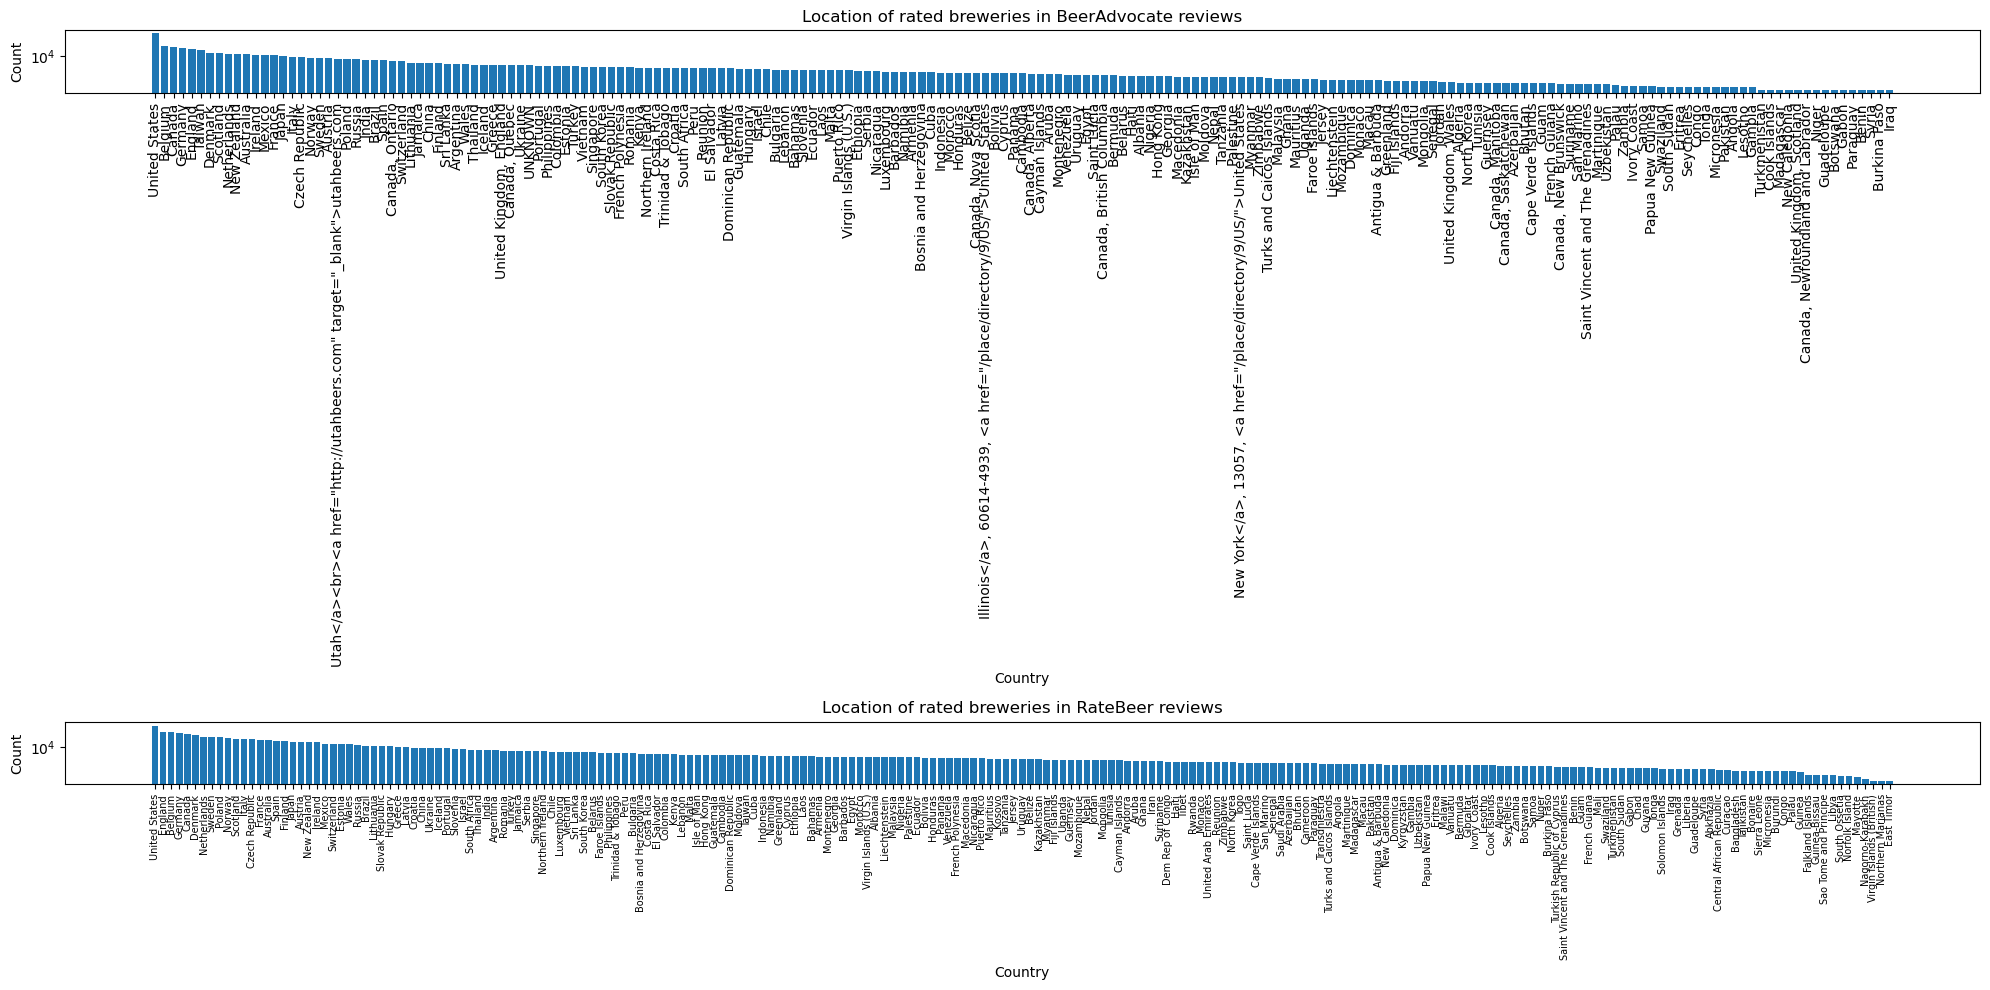

In [87]:
BA_counts_countries_breweries = pd.DataFrame(df_BA_reviews['brewery_merged_location'].value_counts())
BA_counts_countries_breweries.reset_index(inplace=True)

RB_counts_countries_breweries = pd.DataFrame(df_RB_reviews['brewery_merged_location'].value_counts())
RB_counts_countries_breweries.reset_index(inplace=True)

fig, axes = plt.subplots(2,1, figsize=(20,10), sharey=True)

axes[0].bar(x = BA_counts_countries_breweries['index'], height= BA_counts_countries_breweries['brewery_merged_location'])
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[0].set_title('Location of rated breweries in BeerAdvocate reviews')

axes[1].bar(x = RB_counts_countries_breweries['index'], height= RB_counts_countries_breweries['brewery_merged_location'])
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', labelrotation = 90, labelsize=7)
axes[1].set_title('Location of rated breweries in RateBeer reviews')

for ax in axes.flat:
    ax.set(xlabel='Country', ylabel='Count')

fig.tight_layout()

In [88]:
print('Top 10 locations of beers rated in BeerAdvocate:')
display(BA_counts_countries_breweries.head(10))

Top 10 locations of beers rated in BeerAdvocate:


,index,brewery_merged_location
0,United States,4790062
1,Belgium,159917
2,Canada,119992
3,Germany,87747
4,England,71365
5,Taiwan,52937
6,Denmark,24124
7,Scotland,24089
8,Netherlands,17751
9,New Zealand,17038


In [89]:
print('Top 10 locations of beers rated in RateBeer:')
display(RB_counts_countries_breweries.head(10))

Top 10 locations of beers rated in RateBeer:


,index,brewery_merged_location
0,United States,3013577
1,England,646503
2,Belgium,629429
3,Germany,497580
4,Canada,334856
5,Denmark,263815
6,Netherlands,184015
7,Sweden,162142
8,Poland,151208
9,Norway,131294


Now let's look at some of the factors that may influence a beer's liking:

### Most reviewed beer styles

In [95]:
BA_counts_beerstyles = pd.DataFrame(df_BA_reviews['style'].value_counts())
BA_counts_beerstyles.reset_index(inplace=True)

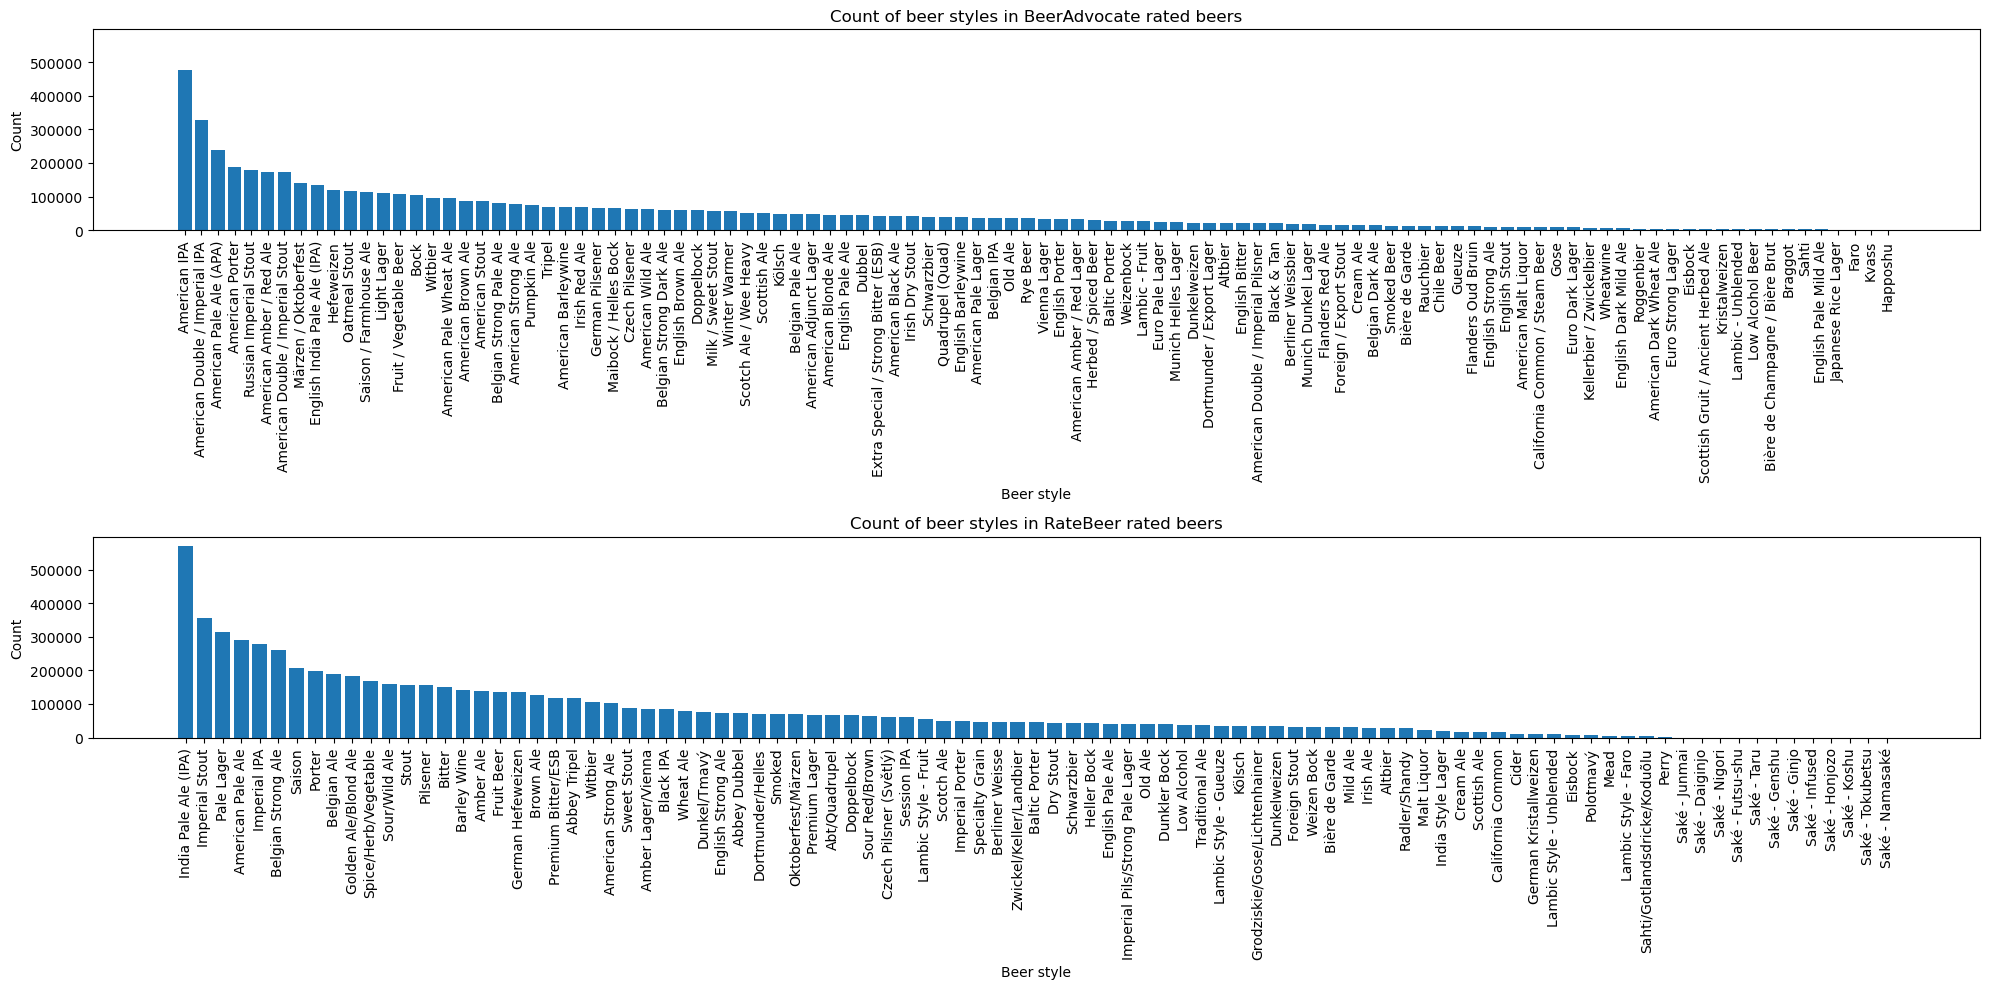

In [111]:
BA_counts_beerstyles = pd.DataFrame(df_BA_reviews['style'].value_counts())
BA_counts_beerstyles.reset_index(inplace=True)

RB_counts_beerstyles= pd.DataFrame(df_RB_reviews['style'].value_counts())
RB_counts_beerstyles.reset_index(inplace=True)

fig, axes = plt.subplots(2,1, figsize=(20,10), sharey=True)

axes[0].bar(x = BA_counts_beerstyles['index'], height= BA_counts_beerstyles['style'])
axes[0].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[0].set_title('Count of beer styles in BeerAdvocate rated beers')

axes[1].bar(x = RB_counts_beerstyles['index'], height= RB_counts_beerstyles['style'])
axes[1].tick_params(axis='x', labelrotation = 90, labelsize=10)
axes[1].set_title('Count of beer styles in RateBeer rated beers')

for ax in axes.flat:
    ax.set(xlabel='Beer style', ylabel='Count')

fig.tight_layout()

In [148]:
print('10 most rated beer styles in BeerAdvocate:')
display(BA_counts_beerstyles.head(10))

10 most rated beer styles in BeerAdvocate:


,index,style
0,American IPA,476266
1,American Double / Imperial IPA,328741
2,American Pale Ale (APA),239882
3,American Porter,187770
4,Russian Imperial Stout,180426
5,American Amber / Red Ale,172989
6,American Double / Imperial Stout,172218
7,Märzen / Oktoberfest,141660
8,English India Pale Ale (IPA),135805
9,Hefeweizen,118767


In [149]:
print('10 most rated beer styles in Ratebeer:')
display(RB_counts_beerstyles.head(10))

10 most rated beer styles in Ratebeer:


,index,style
0,India Pale Ale (IPA),569252
1,Imperial Stout,357125
2,Pale Lager,314360
3,American Pale Ale,291303
4,Imperial IPA,277944
5,Belgian Strong Ale,259439
6,Saison,206645
7,Porter,197759
8,Belgian Ale,188404
9,Golden Ale/Blond Ale,182536


Among the most reviewed beer styles across both websites are IPA and its variations.

### Distribution of ratings across websites

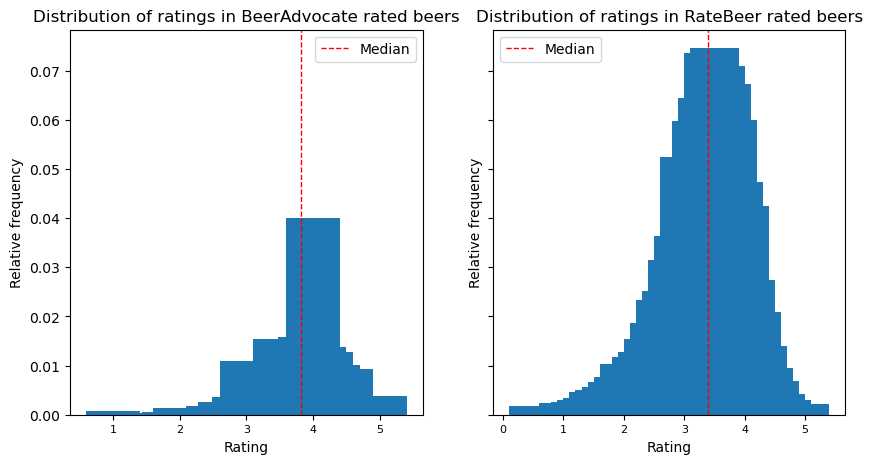

In [145]:
BA_ratings_count = pd.DataFrame(df_BA_reviews['rating'].value_counts(normalize= True))
BA_ratings_count.reset_index(inplace=True)

RB_ratings_count = pd.DataFrame(df_RB_reviews['rating'].value_counts(normalize= True))
RB_ratings_count.reset_index(inplace=True)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey= True)

med_BA = df_BA_reviews['rating'].median()
axes[0].bar(x = BA_ratings_count['index'], height= BA_ratings_count['rating'])
axes[0].tick_params(axis='x', labelrotation = 0, labelsize=8)
axes[0].axvline(x = med_BA, color = 'r', linestyle = 'dashed', linewidth = 1, label='Median')
axes[0].legend()
axes[0].set_title('Distribution of ratings in BeerAdvocate rated beers')

med_RB = df_RB_reviews['rating'].median()
axes[1].bar(x = RB_ratings_count['index'], height= RB_ratings_count['rating'])
axes[1].tick_params(axis='x', labelsize=8)
axes[1].axvline(x = med_RB, color = 'r', linestyle = 'dashed', linewidth = 1, label='Median')
axes[1].legend()
axes[1].set_title('Distribution of ratings in RateBeer rated beers')

for ax in axes.flat:
    ax.set(xlabel='Rating', ylabel='Relative frequency')


We observe visually similar shapes in the distribution (no abormal right or left skewing) with median values of 3.82 and 3.4 for BeerAdvocate and Ratebeer, respectively. 

## Sensorial evaluation  <a class="anchor" id="sensory"></a>

## Location bias  <a class="anchor" id="location"></a>

## Political/Economic climate effect  <a class="anchor" id="political"></a>

***Used DataFrames***

In [ ]:
'''
#Stores only the reviews done by users from the US:
df_US_reviews = df_reviews_all[df_reviews_all['user_merged_location'] == 'United States']
df_US_reviews['date'] = pd.to_datetime(df_US_reviews['date'], format="%Y-%m-%d %H:%M:%S")

df_US_reviews['year'] = df_US_reviews['date'].dt.year
df_US_reviews['month_year'] = df_US_reviews['date'].dt.to_period('M')

#Important for the division later on (to obtain the ratio of reviews per month)
df_US_reviews = df_US_reviews.sort_values('date', ascending=True)

df_US_reviews.to_csv(PATH+'/DataframeStorage/df_US_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location', 'year', 'month_year'], index=False)
'''

Possible columns: <br>
Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', <br>
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',<br>
       'taste', 'overall', 'rating', 'text', 'brewery_location',<br>
       'brewery_merged_location', 'user_location', 'user_merged_location',<br>
       'year', 'month_year'],<br>
      dtype='object')

In [ ]:
df_US_reviews_dates = pd.read_csv(PATH+'/DataframeStorage/df_US_reviews.csv', usecols = ['beer_name','date','month_year', 'year'])
#The transformation will be done only after the interpolation plots, because else there is a problem with the reading of the axis.



### Influence of the financial crisis in 2007/2008 on the appearance of price related words in the ratings.


The general idea is to look whether the price plays a more important role during economically difficult times (which we expect to do). <br>
The approach is to find the text reviews mentionning any price related words and see whether the frequency increased after the onset of the crisis.

First we define the words that we want the text reviews to scan for. <br>

In [ ]:
price_related_words = ['price', 'prices','pricey', 'priced', 'overprice', 'overpriced',\
                         'cheap', 'cheaper', 'cheapest', \
                         'dollar', 'dollars', '$', 'money', 'cost', 'costs', 'costly', 'costing' \
                         'expensive', 'inexpensive', 'expense', 'expenses',\
                         'budget', 'affordable']

In the following cell we have the algorithm extracting the indices for the reviews where the words are mentionned. <br>
We run the algorithm only once and save the list of indices as a pickle that we can open easily.

In [ ]:

'''
index_price = []
k = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ$"

df_US_reviews_texts = pd.read_csv(PATH+'/DataframeStorage/df_US_reviews.csv', usecols = ['text'])

for index, row in df_US_reviews_texts.iterrows():
    #extract the text
    text = str(row['text'])
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in price_related_words]) > 0):
        index_price.append(index)
    

'''


In [ ]:
index_price = []
with open("../DataframeStorage/index_price.bin", "wb") as output:
    pickle.dump(index_price, output)

Open the pickle as a list:

In [ ]:
with open("../DataframeStorage/index_price.bin", "rb") as data:
    index_price = pickle.load(data)

In [ ]:
print(str(len(index_price)) + ' of the reviews mention prices')

237917 of the reviews mention prices


We have almost 240'000 american reviews mentionning price related words.

In [ ]:
#init_dataframe
df_price_related = df_US_reviews_dates.loc[index_price]
#Important for the division later on (to obtain the ratio of reviews per month)
#Maybe the sorting is not required
df_price_related = df_price_related.sort_values('date', ascending=True)

df_price_related.head(2)

,beer_name,date,year,month_year
9,Bigfoot Barleywine-Style Ale,1998-02-06 11:00:00,1998,1998-02
20,Ommegang (Abbey Ale),1998-02-18 11:00:00,1998,1998-02


**Visualizations**

In [ ]:
#Reviews per month mentioning price related words
monthly_counts_price_reviews = df_price_related.groupby('month_year').count().reset_index()

#Total number of reviews of US users
#We remove all month that have lower counts than 50 
monthly_counts_US_reviews = df_US_reviews_dates.groupby('month_year').count().reset_index()
monthly_counts_US_reviews = monthly_counts_US_reviews[monthly_counts_US_reviews['beer_name']>50]

#Define a dataframe that contains the percentage of reviews mentionning price per month:
#First we extract the data of the monthly counts and the corresponding month/years.
price_count = monthly_counts_price_reviews[['month_year', 'beer_name']]
review_count = monthly_counts_US_reviews[['month_year', 'beer_name']]

#The two counts are merged over the dates and the columns are renamed. Subsequently the ratio is calculated and stored in a new column.
df_ratio = price_count.merge(review_count, on='month_year')
df_ratio.rename(columns = {'beer_name_x':'price_related', 'beer_name_y':'all_reviews'}, inplace = True)
df_ratio['ratio'] = (df_ratio['price_related']/df_ratio['all_reviews']*100).round(2)


#Define ticks:
major_ticks = np.linspace(9,201,17).astype(int)
minor_ticks = np.asarray(range(208))
minor_ticks = [i for i in minor_ticks if i not in major_ticks]

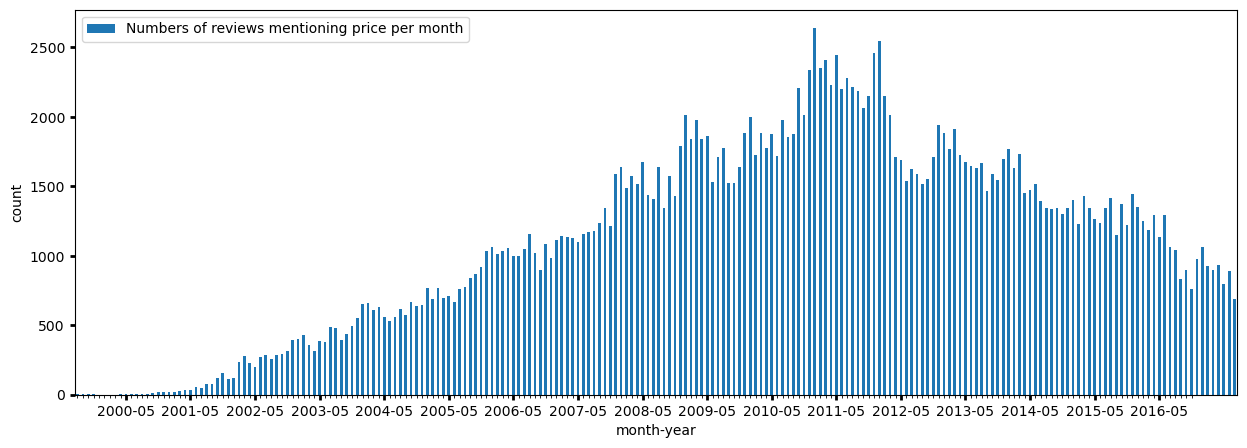

In [ ]:
axes = monthly_counts_price_reviews.plot.bar(x = 'month_year', y='beer_name', figsize=(15,5), rot=0)

#set labels
axes.set_ylabel('count')
axes.set_xlabel('month-year')
axes.legend(['Numbers of reviews mentioning price per month'])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)


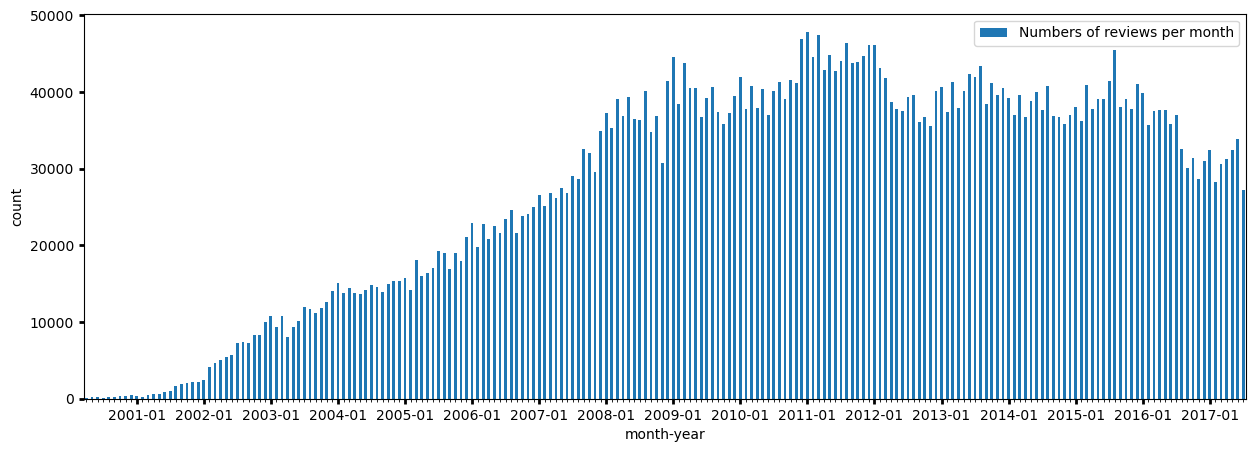

In [ ]:
axes = monthly_counts_US_reviews.plot.bar(x = 'month_year', y='beer_name', figsize=(15,5), rot=0)

#set labels
axes.set_ylabel('count')
axes.set_xlabel('month-year')
axes.legend(['Numbers of reviews per month'])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


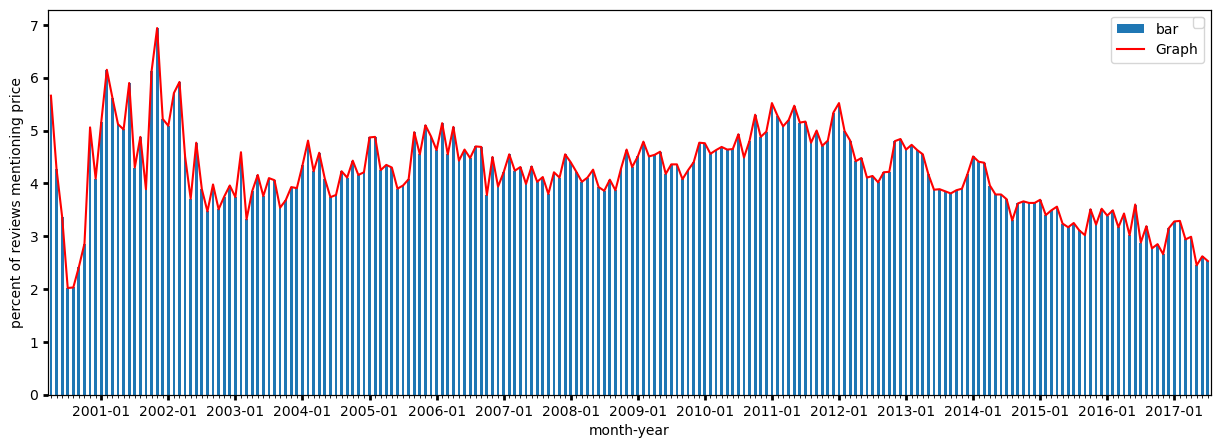

In [ ]:
#plot the ratios as bar plots
axes = df_ratio.plot.bar(x = 'month_year', y='ratio', figsize=(15,5), label='bar')
#Connect the bars with a graph
ax2 = axes.twinx()
df_ratio.plot.line(y='ratio', figsize=(15,5), color='red', ax=axes, label='Graph')

#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('month-year')
plt.legend()

#keep only the y-axis on the left
ax2.yaxis.set_ticks([])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)

plt.show()

Next we want to approximate a function that shows the global trends. <br>
To approximate the graph we use an approach called interpolation. <br>
A function of degree N is defined. <br>
If the function is dependent on x, *f(x)*, then f(x) = aN*x^(N) + a(N-1) * x(N-1) + .... + a1 * X + a0 <br>
The different parameter a are chosen in a way that minimizes the error between the original points and the points approximated by f. <br>
The higher N, the more we risk to overfit. Meaning that our function is very close to all the points, but fails to describe the global trends. <br>
It will also incorporate the natural variations of the measurements. <br>
We, however, are not interested in the variations but only in the global trends. <br>

To chose an appropriate N, we plot several interpolations with different parameters and compare them.

Try different interpolations:

c:\Users\flori\anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


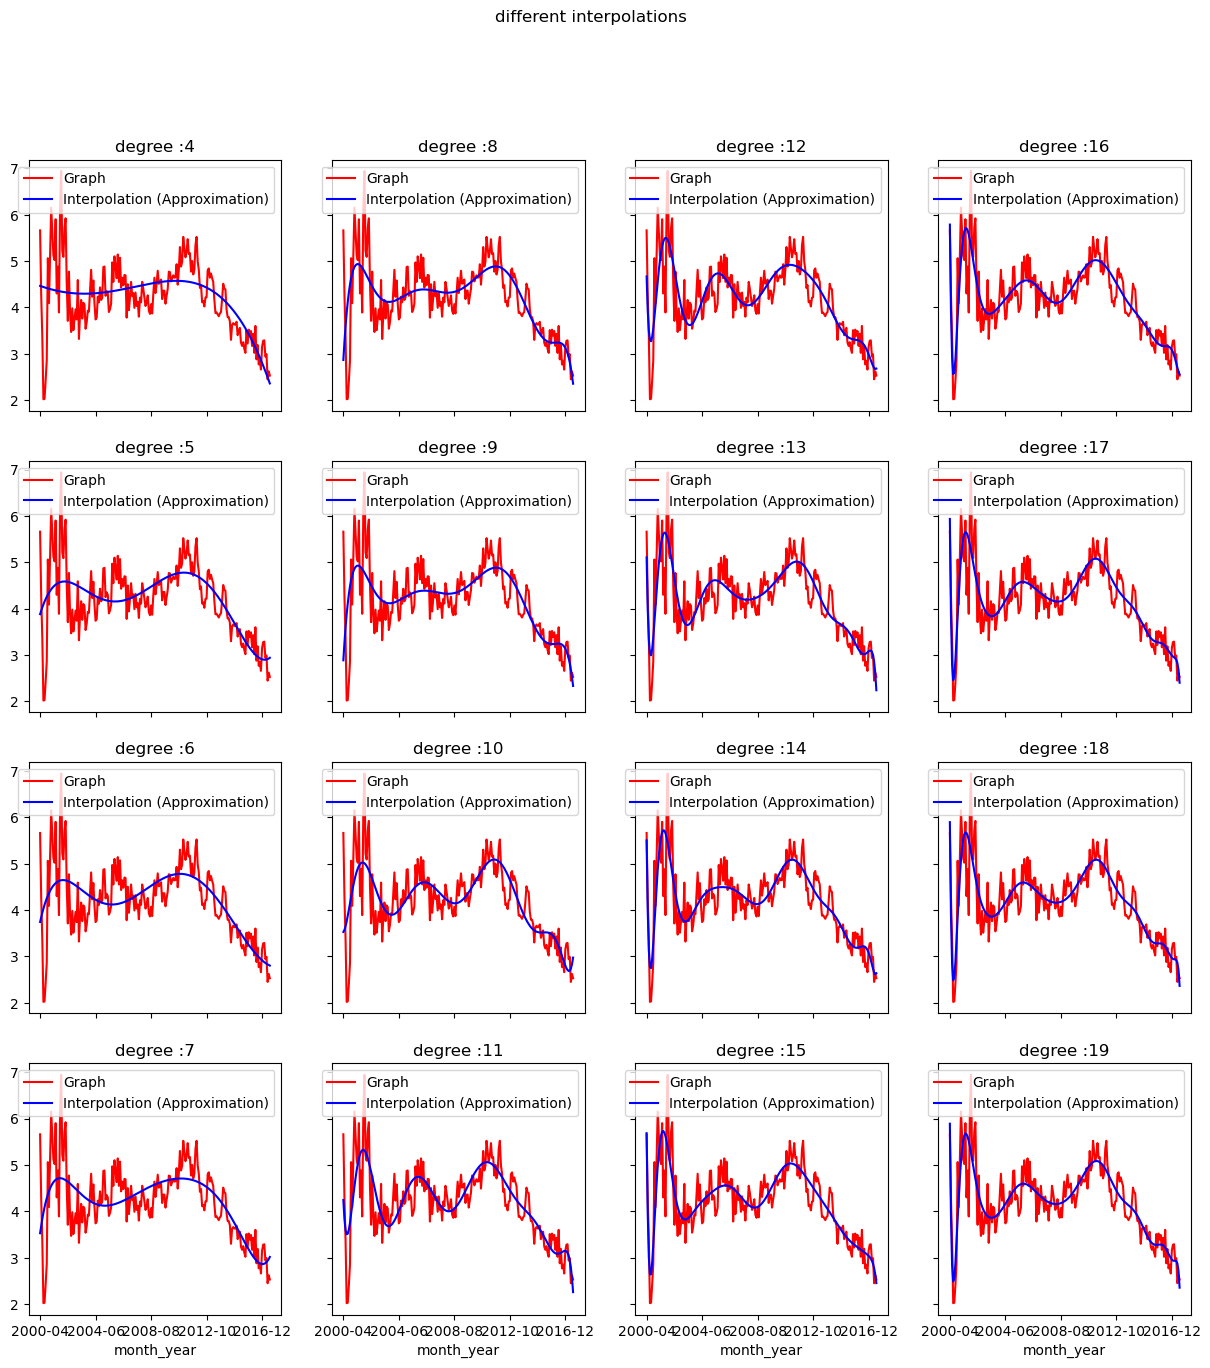

In [ ]:
fig, axes = plt.subplots(4,4,figsize = (15,15), sharey=True, sharex=True)
fig.suptitle('different interpolations')

for i in range(4,20):
    sbplt = axes[(i-4)%4, math.floor((i-4)/4)]
    sbplt.set_title('degree :' + str(i))
    

    poly = np.polyfit(df_ratio.index,df_ratio['ratio'],i)
    poly_y = np.poly1d(poly)(df_ratio.index)
    poly_y_series = pd.Series(poly_y)
    df_ratio['interpolate'] = poly_y_series

    df_ratio.plot.line(x='month_year', y='ratio', color='red', ax=sbplt, label='Graph')
    df_ratio.plot.line(y='interpolate', color='blue', ax=sbplt, label='Interpolation (Approximation)')

There is no right or wrong in the choice of the degree. <br>
It is a tradeoff between losing global trends or losing small variations. <br>
On these small graphs we chose that N=9 does not represent enough variations. <br>

So, we will take a closer look at the interpolations for N=10 to N=19:

c:\Users\flori\anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


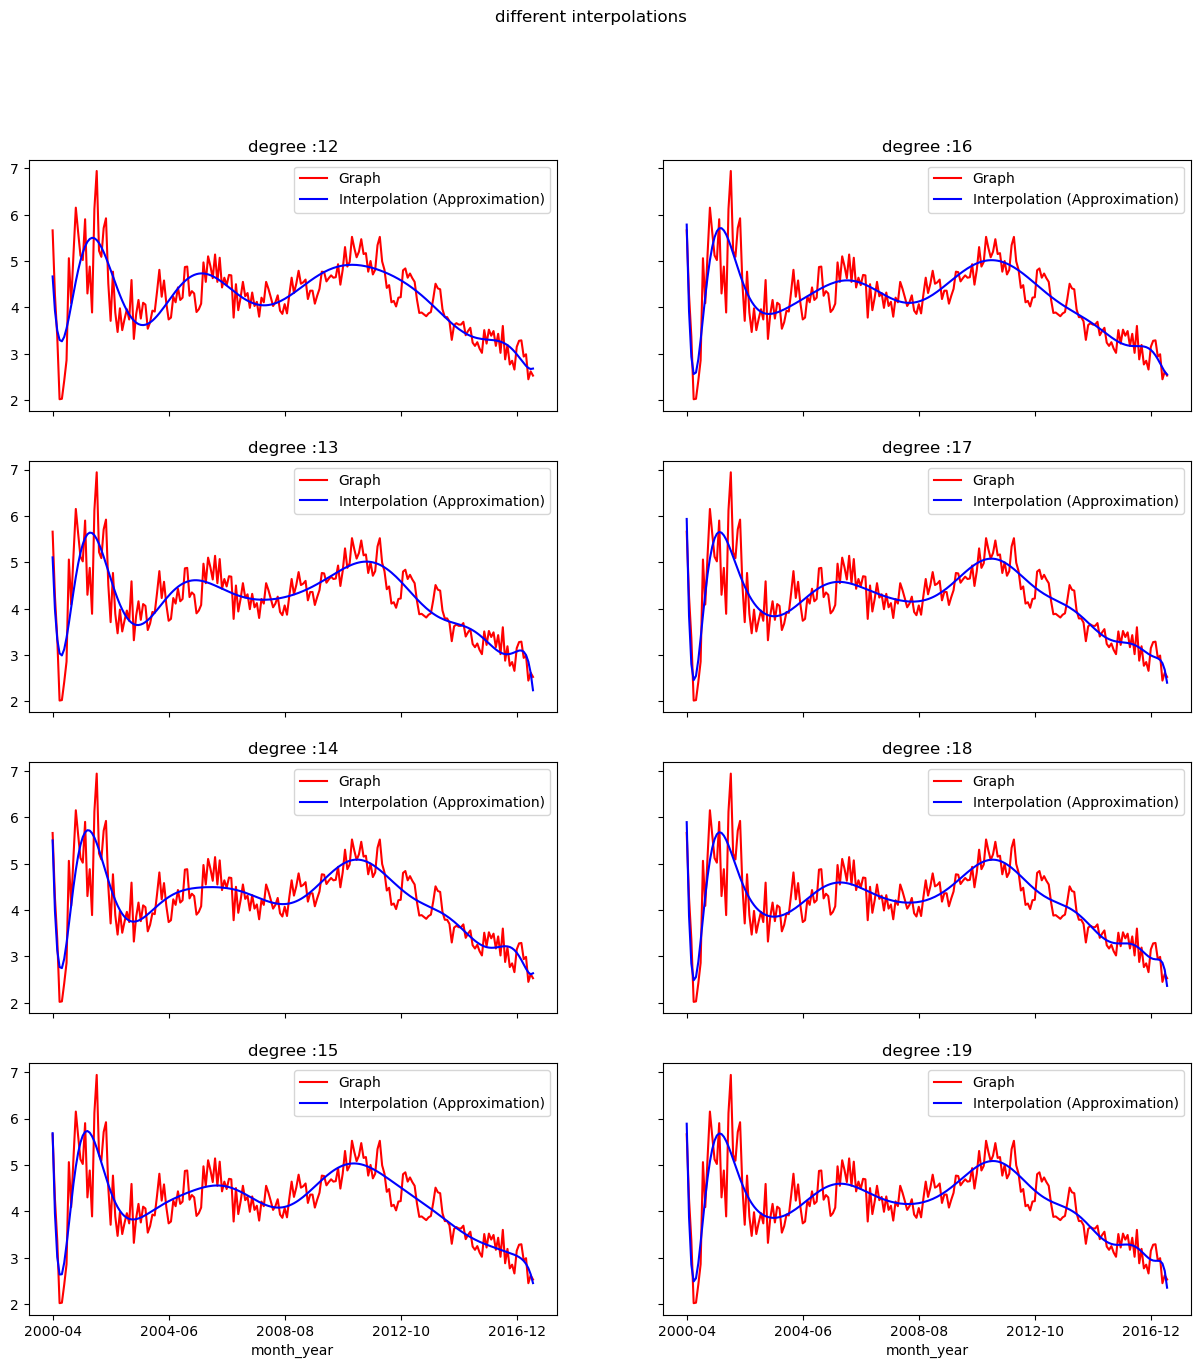

In [ ]:
fig, axes = plt.subplots(4,2,figsize = (15,15), sharey=True, sharex=True)
fig.suptitle('different interpolations')

for i in range(12,20):
    sbplt = axes[(i-12)%4, math.floor((i-12)/4)]
    sbplt.set_title('degree :' + str(i))
    

    poly = np.polyfit(df_ratio.index,df_ratio['ratio'],i)
    poly_y = np.poly1d(poly)(df_ratio.index)
    poly_y_series = pd.Series(poly_y)
    df_ratio['interpolate'] = poly_y_series

    df_ratio.plot.line(x='month_year', y='ratio', color='red', ax=sbplt, label='Graph')
    df_ratio.plot.line(y='interpolate', color='blue', ax=sbplt, label='Interpolation (Approximation)')

plt.show()

For N > 15 we do not see much improvement for the increase in complexity of the function. <br>
We take a closer look at N=10 to N = 15

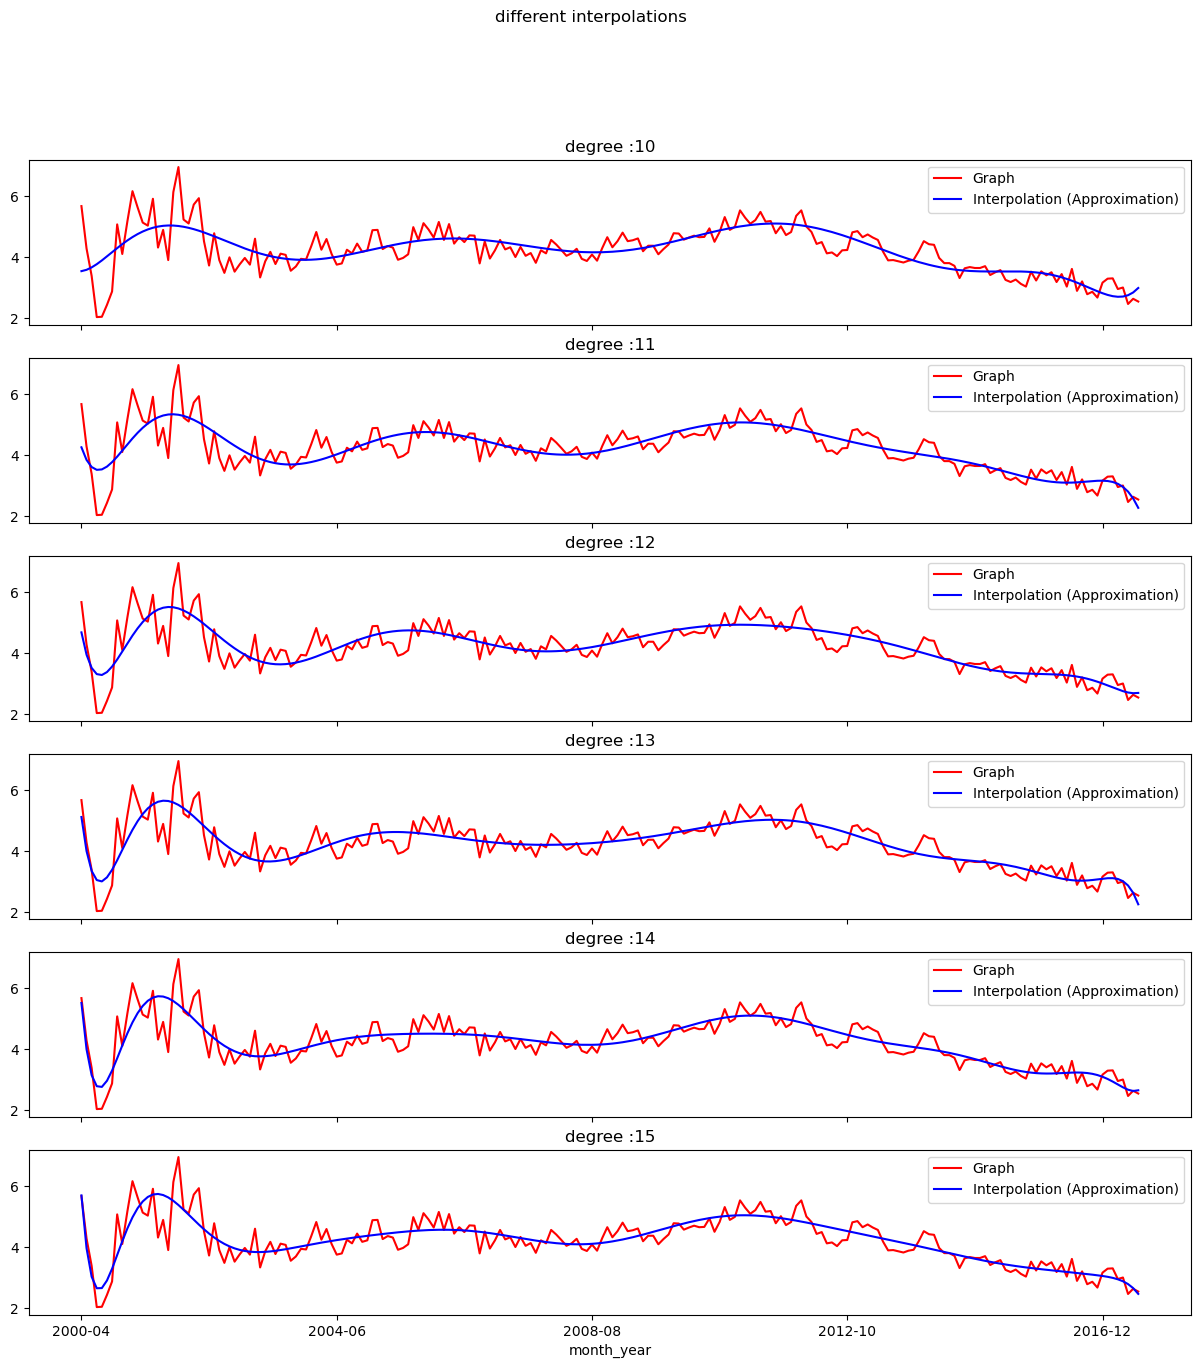

In [ ]:
fig, axes = plt.subplots(6,1,figsize = (15,15), sharey=True, sharex=True)
fig.suptitle('different interpolations')

for i in range(10,16):
    sbplt = axes[(i-10)]
    sbplt.set_title('degree :' + str(i))
    

    poly = np.polyfit(df_ratio.index,df_ratio['ratio'],i)
    poly_y = np.poly1d(poly)(df_ratio.index)
    poly_y_series = pd.Series(poly_y)
    df_ratio['interpolate'] = poly_y_series

    df_ratio.plot.line(x='month_year', y='ratio', color='red', ax=sbplt, label='Graph')
    df_ratio.plot.line(y='interpolate', color='blue', ax=sbplt, label='Interpolation (Approximation)')

plt.show()

In order to be able to sufficiently grasp the first low point in the beginning, without having a too high complexity, we will continue with an interpolation of degree 14.

In [ ]:
poly = np.polyfit(df_ratio.index,df_ratio['ratio'],14)
poly_y = np.poly1d(poly)(df_ratio.index)
poly_y_series = pd.Series(poly_y)
df_ratio['interpolate'] = poly_y_series

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


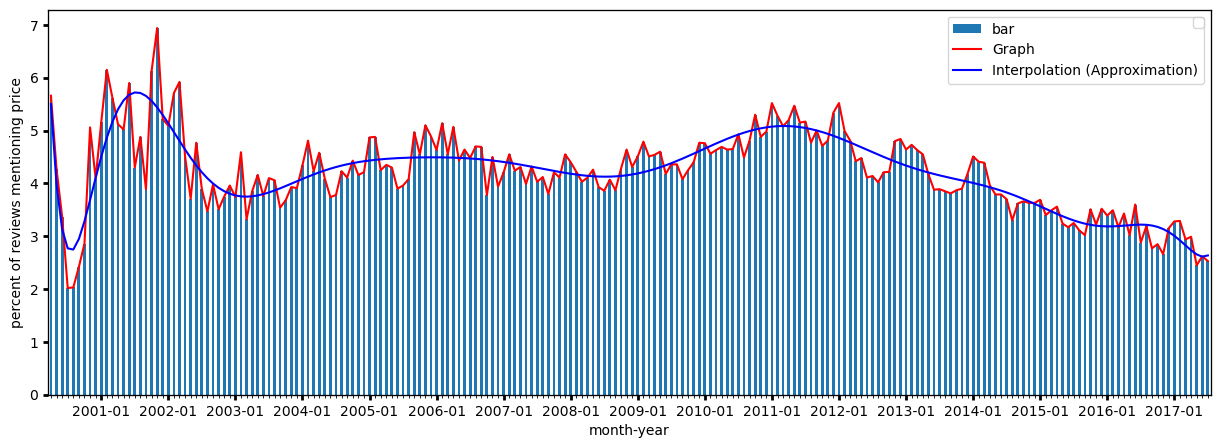

In [ ]:
#plot the ratios as bar plots
axes = df_ratio.plot.bar(x = 'month_year', y='ratio', figsize=(15,5), label='bar')
#Connect the bars with a graph
ax2 = axes.twinx()
df_ratio.plot.line(y='ratio', figsize=(15,5), color='red', ax=axes, label='Graph')
#Plot the interpolation of degree 14
ax3 = axes.twinx()
df_ratio.plot.line(y='interpolate', figsize=(15,5), color='blue', ax=axes, label='Interpolation (Approximation)')

#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('month-year')
plt.legend()

#keep only the y-axis on the left
ax2.yaxis.set_ticks([])
ax3.yaxis.set_ticks([])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)

plt.show()

The interpolation allows us already to grasp a bit the global trends. <br>
To make the readout easier, the derivative of the interpolation is calculated.

In [ ]:
#Function to calculate the derivative of a function f
def derivative(f):
    #The length describes the current degree of the function as every entry describes the constant multiplied by the variable to a given power
    length = len(f) - 1
    # d_f is the vector where the new constants are safed
    d_f = []
    #in the derivative the last parameter (a0*x^0) will be zero, therefore we iterate only to the second last element
    for index, a in enumerate(f[:-1]):
        #while iterating we start with the constant of the highest power
        power = length - index
        #The element at the first position will be a times the power. As d_f will have one element fewer than f, the constant will automatically belong to the variable x with a power of one less.
        d_f.append(power * a)
        
    return np.asarray(d_f)

Calculate the values of the derivative of the approximation function:

In [ ]:
d_f = derivative(poly)
d_f_poly_y = np.poly1d(d_f)(df_ratio.index)
d_f_poly_y_series = pd.Series(d_f_poly_y)
df_ratio['derivative'] = d_f_poly_y_series

The derivative gives us information about the the trend of the approximation - curve. <br>
Is the curve rising, the derivative is positive, is it decreasing the derivative is negative. <br>
To visualize that, it helps to color the increasing periods in one and the decreasing periods in another color. <br>
To do that we find the points when the sign of the derivative changes from positive to negative or vice versa.

In [ ]:
derivative_ = df_ratio['derivative']
changes_in_sign_positions = []
sign = 0

#store all the positions at which the sign of the derivative changes.
for index, value in enumerate(derivative_):
    if (sign == 0):
        changes_in_sign_positions.append(index)
        if(value < 0):
            sign = -1
        if(value > 0):
            sign = 1
    if ((sign != -1) & (value < 0)):
        sign = -1
        changes_in_sign_positions.append(index-1)
    if ((sign != 1) & (value > 0)):
        sign = 1
        changes_in_sign_positions.append(index-1)


#add the last index to be able to color the last part too
changes_in_sign_positions.append(len(derivative_))


Next, the derivative is plotted together with the colors. <br>
Green means positive (increasing), red means negative (decreasing)

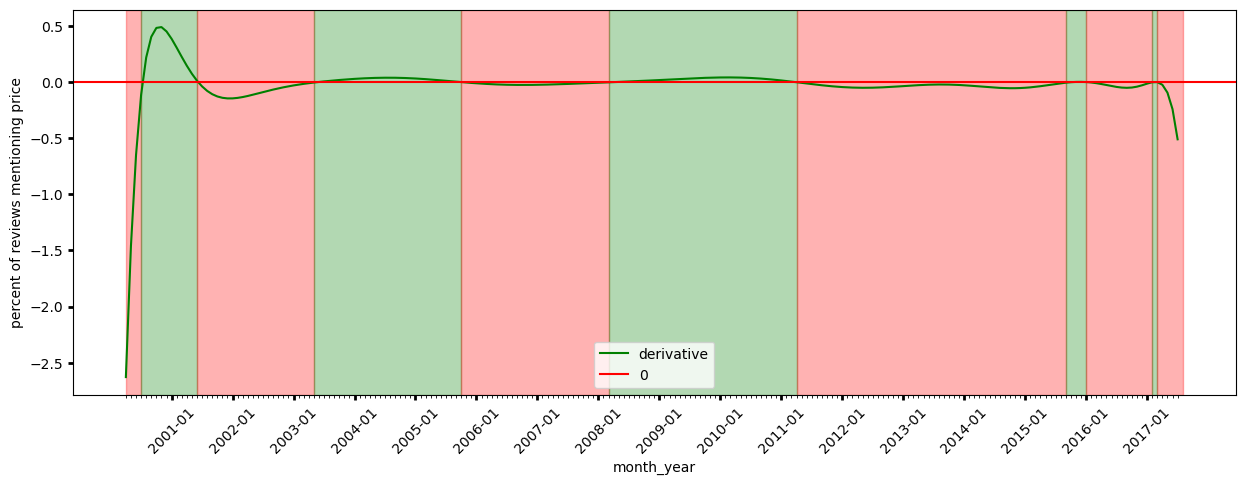

In [ ]:
#Plot the derivative
axes = df_ratio.plot.line(x = 'month_year', y='derivative', figsize=(15,5), color='green', label='derivative')
#Plot the horizontal line for y=0
plt.axhline(y=0, color='r', label='0')

#set labels
plt.ylabel('percent of reviews mentioning price')
plt.legend()

#Color the background in red if derivative is negative and green if derivative is positive
colors = ['red', 'green']
for i in range(len(changes_in_sign_positions)-1):
    plt.axvspan(changes_in_sign_positions[i], changes_in_sign_positions[i+1], alpha=0.3, color=colors[i%2])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)
axes.set_xticklabels(df_ratio.iloc[major_ticks]['month_year'], rotation=45, ha='center')

plt.show()

We can see that the coloring is succesful. <br>
It would now be interesting to have the same coloring together in the barplot of the ratios.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


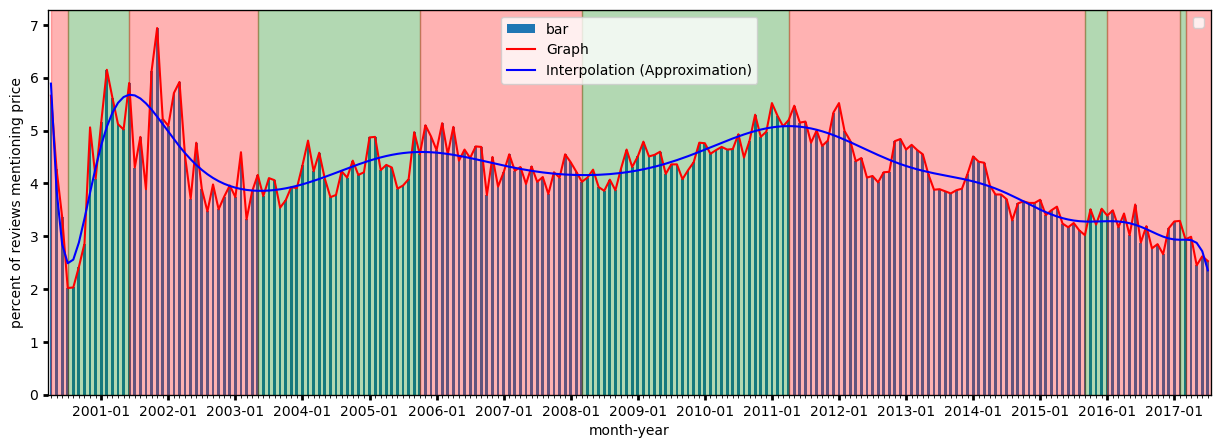

In [ ]:
#plot the ratios as bar plots
axes = df_ratio.plot.bar(x = 'month_year', y='ratio', figsize=(15,5), label='bar')
#Connect the bars with a graph
ax2 = axes.twinx()
df_ratio.plot.line(y='ratio', figsize=(15,5), color='red', ax=axes, label='Graph')
#Plot the interpolation of degree 14
ax3 = axes.twinx()
df_ratio.plot.line(y='interpolate', figsize=(15,5), color='blue', ax=axes, label='Interpolation (Approximation)')

#Color the background in red if derivative is negative and green if derivative is positive
colors = ['red', 'green']
labels_ = ['decreasing', 'increasing']
for i in range(len(changes_in_sign_positions)-1):
    #We only want to label the first two spans, to avoid having multiple labels
    #To do so we can add a '_' to all labels except the first two
    #Labels that start with '_' are ignored later on
    #We use rounding to have zero for all i bigger than 1 (we need add 0.1 because round() rounds down 0.5)
    factor = 1 - round(1/(i+1) + 0.1)
    axes.axvspan(changes_in_sign_positions[i], changes_in_sign_positions[i+1], alpha=0.3, color=colors[i%2], label=factor*'_'+labels_[i%2])

#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('month-year')
plt.legend()

#keep only the y-axis on the left
ax2.yaxis.set_ticks([])
ax3.yaxis.set_ticks([])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)

plt.show()

In the illustration we see that indeed after the crisis in 2008, the ratio of reviews that mention the price increased until 2011. <br>
It subsequently decreased until the end of data collection. <br>
But just having a curve with positive or negative slope does not tell us anything about statistical significance. <br>
The curve is very unlikely to be flat, so by natural variations we expect some changes. <br>

To get a statistical readout we will do several steps: <br>
First, the intervals of measurements need to be increased. <br>
If we plot every month, we can see big fluctuations, that will possibly be significant in a lot of cases, but poorly represent the global trends. <br>
We try three different intervals: by quartals (take 3 month together), by semesters (take 6 month together) and by years. <br>
They are grouped and the average ratio is taken. <br>

In [ ]:
#To allow grouping we add the date, year, semester and quarter to the dataframe containing the ratios.
df_ratio['date'] = df_ratio['month_year']
df_ratio['date'] = pd.to_datetime(df_ratio['date'], format="%Y-%m")
df_ratio['year'] = df_ratio['date'].dt.year
df_ratio['semester'] = (df_ratio['date'].dt.month.astype(int) - 1) // 6
df_ratio['quarter'] = (df_ratio['date'].dt.month.astype(int) - 1) // 3

Next the ratios are grouped by quarter, semester and year. <br>
Note, the ratio average are taken to allow plotting of the ratio values over the given time period. <br>
The sum of the count of reviews mentioning price and the sum of the count of all reviews are only calculated for the semesterly_ratios. <br>
This is because we will decide to do the statistical analysis for the time interval of semesters. <br>
The explanation follows later on.

In [ ]:
quarterly_ratios = df_ratio.groupby(['year', 'quarter']).agg({'ratio': 'mean', 'interpolate':'mean'})
semesterly_ratios = df_ratio.groupby(['year', 'semester']).agg({'ratio': 'mean', 'interpolate':'mean', 'price_related':'sum','all_reviews':'sum'})
yearly_ratios = df_ratio.groupby('year').agg({'ratio': 'mean', 'interpolate':'mean'})

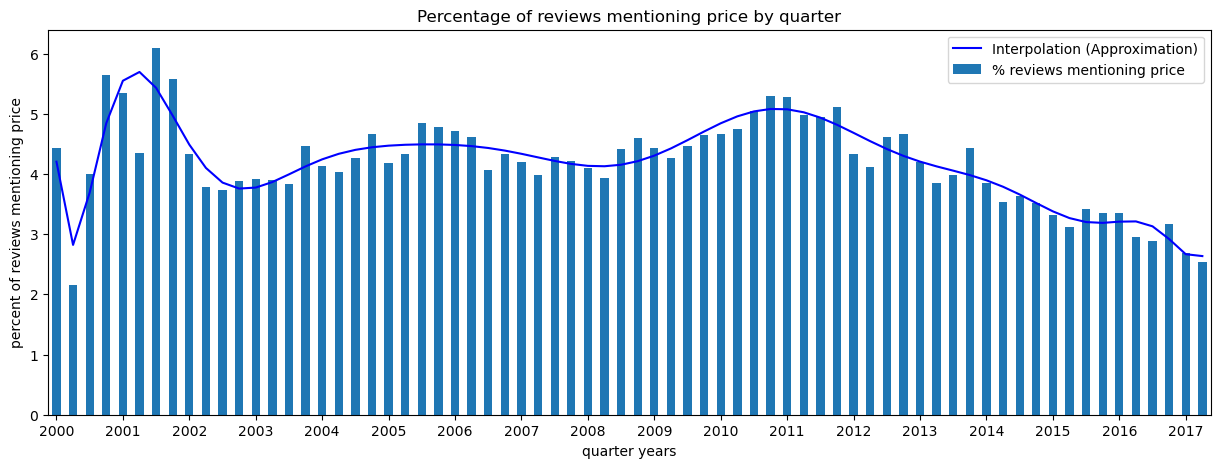

In [ ]:
#plot the ratios as bar plots
axes = quarterly_ratios.plot.bar(y='ratio', figsize=(15,5), label='% reviews mentioning price')
#Plot the interpolation of degree 14
quarterly_ratios.plot.line(y='interpolate', figsize=(15,5), color='blue', ax=axes, label='Interpolation (Approximation)')

#set labels
plt.title('Percentage of reviews mentioning price by quarter')
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('quarter years')
plt.legend()

#set ticks
labels_ = [item[0] for item in quarterly_ratios.index]
axes.set_xticklabels(labels_)

#Hide every second x tick
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 4 != 0:
        xticks[i].set_visible(False)

plt.show()

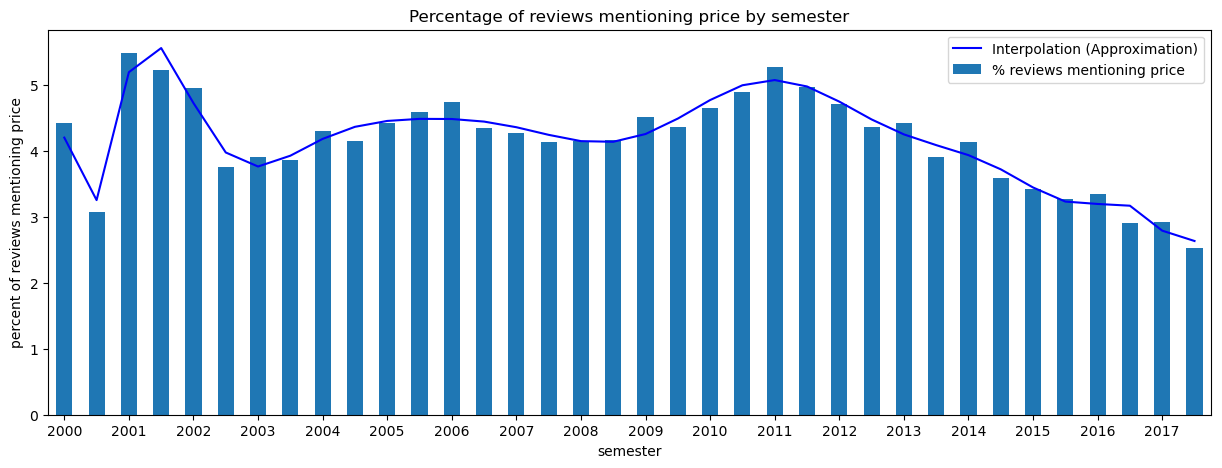

In [ ]:
#plot the ratios as bar plots
axes = semesterly_ratios.plot.bar(y='ratio', figsize=(15,5), label='% reviews mentioning price')
#Plot the interpolation of degree 14
semesterly_ratios.plot.line(y='interpolate', figsize=(15,5), color='blue', ax=axes, label='Interpolation (Approximation)')

#set labels
plt.title('Percentage of reviews mentioning price by semester')
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('semester')
plt.legend()

#set ticks
labels_ = [item[0] for item in semesterly_ratios.index]
axes.set_xticklabels(labels_)

#Hide every second x tick
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 2 != 0:
        xticks[i].set_visible(False)

plt.show()

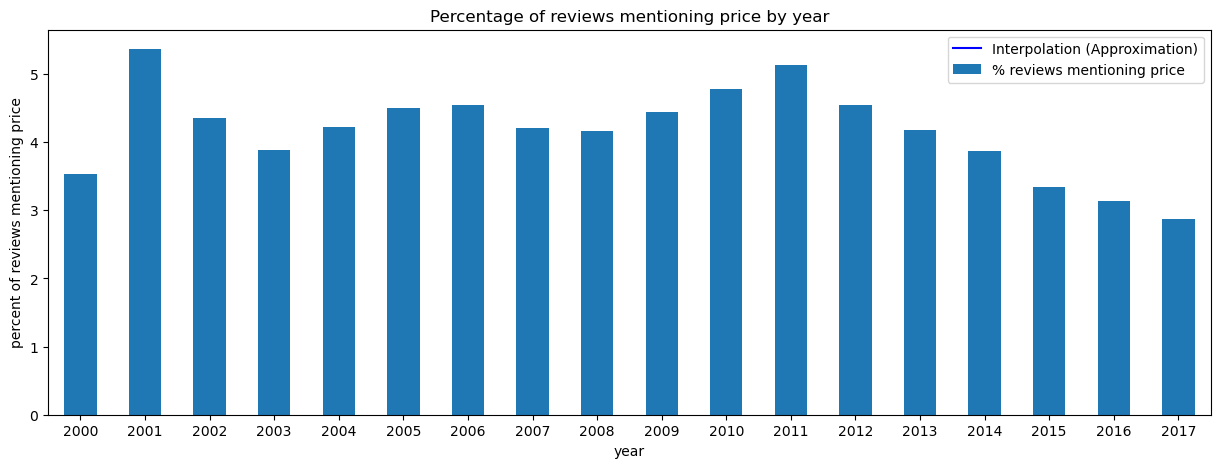

In [ ]:
#plot the ratios as bar plots
axes = yearly_ratios.plot.bar( y='ratio', figsize=(15,5), label='% reviews mentioning price')
#Plot the interpolation of degree 14
yearly_ratios.plot.line(y='interpolate', figsize=(15,5), color='blue', ax=axes, label='Interpolation (Approximation)')


#set labels
plt.title('Percentage of reviews mentioning price by year')
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('year')
plt.legend()

plt.show()

For some mysterious reason, the graph cannot be plotted on the bar plot.

The choice of the time period is a bit of a trade off. <br>
The bigger the period, the less variation, but we also lose temporal information. <br>
We decided to do the statistical analysis with the semester time interval (6 month per group)

For the statistical analysis we will do a Chi Square test for every semester to the next. <br>
The chi square test of independence test whether the probability for an outcome (here the probability that a price related word is mentioned) is independent of the group (in this example the semester). <br>
The theory behind is the following: <br>
First a table is set up where the rows separate the groups (semester 1 and semester 2) and the columns separate the outcome (price mentioned or not). <br>
In the field the number of individuals from the groups are noted (O for observed). <br>
The total for every group and outcome is computed and noted in the column and row "Total. <br>
Next, it is calculated how many individuals would be expected in every group, if the groups were independent. <br>
To do so, one multiplies the probability for being in the given group with the probability for the given otucome times the total number of samples. <br>
The Chi-square is a way of quantifying how far away the observed values are from the expected ones. <br>
The following formula is used: <br>

$\Chi^2 = \sum_{ij} {{(O_ij - E_ij)^2}\over {E_ij}}$


![title](./Graphics/ChiSquareGraphic.JPG)

Knowing the degree of freedom and the $\Chi^2$-value, one can simply readout the p-value from a given table. <br>
The p-value describes how likely it is to get the observed result assuming the null hypothesis (that the ratio is independent of the semester) is true. <br>
So, the smaller the p-value, the less likely the obtained results would be given the case of independence. <br>
For statistical significance we use the widely accepted threshold of 0.05 for the p-value.

In [ ]:
import scipy.stats as stats

**Assumptions**: <br>
We have four assumptions in the Chi-Square test: <br>

First: Categorical: <br>
Both variables have to be categorical. <br>
In our case one variable is the semester and the other one is a binary variable describing whether or not a price related word was mentioned in the review. <br>
Both variables are therefore categorical.

Second: Independence: <br>
We assume that all measurements are independent of each other. Meaning, that the outcome of no sample has an influence on the outcome of other samples. <br>
For this assumption we need to do a compromise. <br>
There could be herding effects, where reading price related reviews, makes the topic more present and therefore gets people to mention prices that would not have thought of this aspect without other reviews. <br>
There is also the possibility of the same user giving several feedbacks, which would also not be independent. <br>
However, we still consider the Chi-Square test appropriate for our question.

Third: Mutual exclusiveness: <br>
Meaning that samples can only belong to one cell at the time. <br>
This is given, as a review cannot be given at two time points (therefore belonging only to one semester) and it can not mention and not mention price related words.

Fourth: Expected value must be bigger than 5: <br>
To get a meaningful result, one should not get any expected values below 5. <br>
Note that observed values below 5 do not cause any problem as long as the expected values are big enough. <br>
A function is added to the code, to check for this assumption, that would notify the user in case of a too low expected value.

In [ ]:
p_values = []

for i in range(len(semesterly_ratios)-1):

    #define group names ('year/semester'):
    group1_name = str(semesterly_ratios.index[i][0]) + '/' + str(semesterly_ratios.index[i][1])
    group2_name = str(semesterly_ratios.index[i+1][0]) + '/' + str(semesterly_ratios.index[i+1][1])
    merged_name = group1_name + ' - ' + group2_name

    #first group (get the number of price related reviews for the given semester)
    group1_price_related = semesterly_ratios.iloc[i]['price_related']
    #(get the number of reviews not mentionning price (all_reviews - price_mentionning_reviews))
    group1_non_price_related = semesterly_ratios.iloc[i]['all_reviews'] - semesterly_ratios.iloc[i]['price_related']
    #following group: same as before but for the subsequent semester
    group2_price_related = semesterly_ratios.iloc[i+1]['price_related']
    group2_non_price_related = semesterly_ratios.iloc[i+1]['all_reviews'] - semesterly_ratios.iloc[i+1]['price_related']

    #prepare the data list for the Chi-test:
    data = [[group1_price_related, group1_non_price_related],
            [group2_price_related, group2_non_price_related]]
    
    #The Chi-test returns us the Chi-value, the p-value, the degrees of freedom and the expected values:
    results = stats.chi2_contingency(data)
    data_expected = results[3]
    p_value = results[1]

    #One of the assumptions for the Chi-square test is that all expected values are bigger than 5
    if (min(list(map(min,data_expected))) < 5):
        print('Chi-square cannot be done, as at least one expected value is smaller than 5.')
    else:
        p_values.append({'name': merged_name, 'p_value':p_value})


To plot the results more easily, the list that stores the p-values and the names is transformed to a dataframe.

In [ ]:
p_values = pd.DataFrame(p_values)

First, the p-values are plotted. <br>
Note that the horizontal line at 0.05 describes the cutoff for statistical significance.

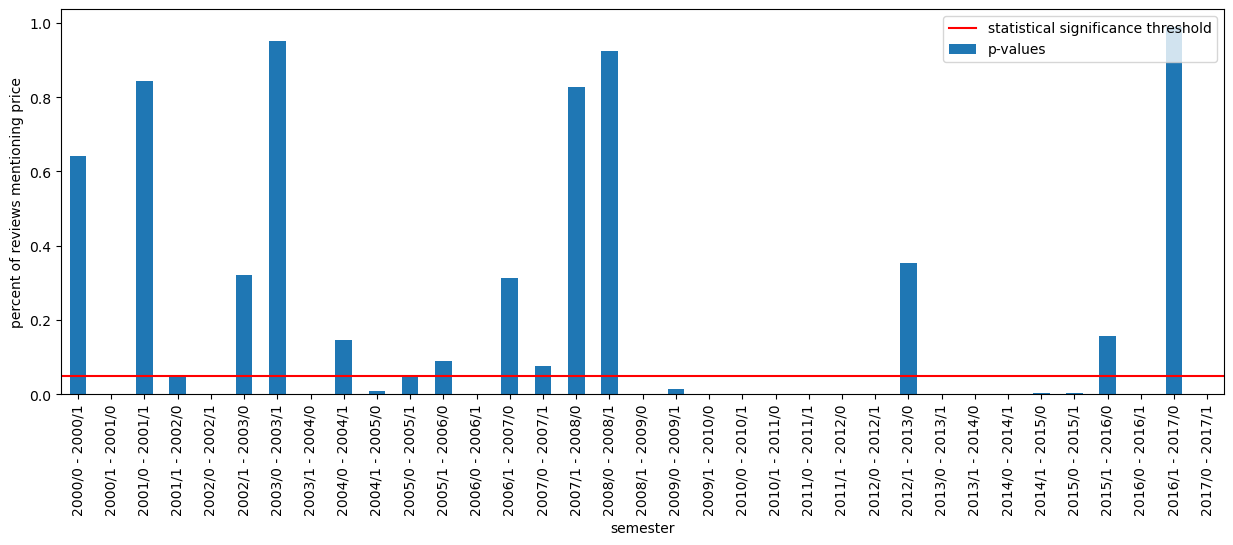

In [ ]:
#plot the ratios as bar plots
axes = p_values.plot.bar(x='name', y='p_value', figsize=(15,5), label='p-values')
plt.axhline(y=0.05, color='r', label='statistical significance threshold')

#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('semester')
plt.legend()

plt.show()

To visualize in which temporal intervals the change in frequency of appearance of price related words in the reviews is significant, we use colors. <br>
To distinguish significant from non-significant intervals, we store the positions when the change goes from significant to unsignificant or vice-versa.

In [ ]:
p_values_series = p_values['p_value']
changes_in_significance_positions = []
sign = 0

#store all the positions where the significance level changes:
for index, value in enumerate(p_values_series):
    if (sign == 0):
        changes_in_significance_positions.append(index)
        if(value < 0.05):
            sign = 1
        if(value > 0.05):
            sign = -1
    if ((sign != -1) & (value > 0.05)):
        sign = -1
        changes_in_significance_positions.append(index-1)
    if ((sign != 1) & (value < 0.05)):
        sign = 1
        changes_in_significance_positions.append(index-1)


#add the last index to be able to color the last part too
changes_in_significance_positions.append(len(p_values_series+1))

We plot in green all the intervals wehere the change is considered significant. <br>
The first plot is to control that the intervals are indeed at the right positions.

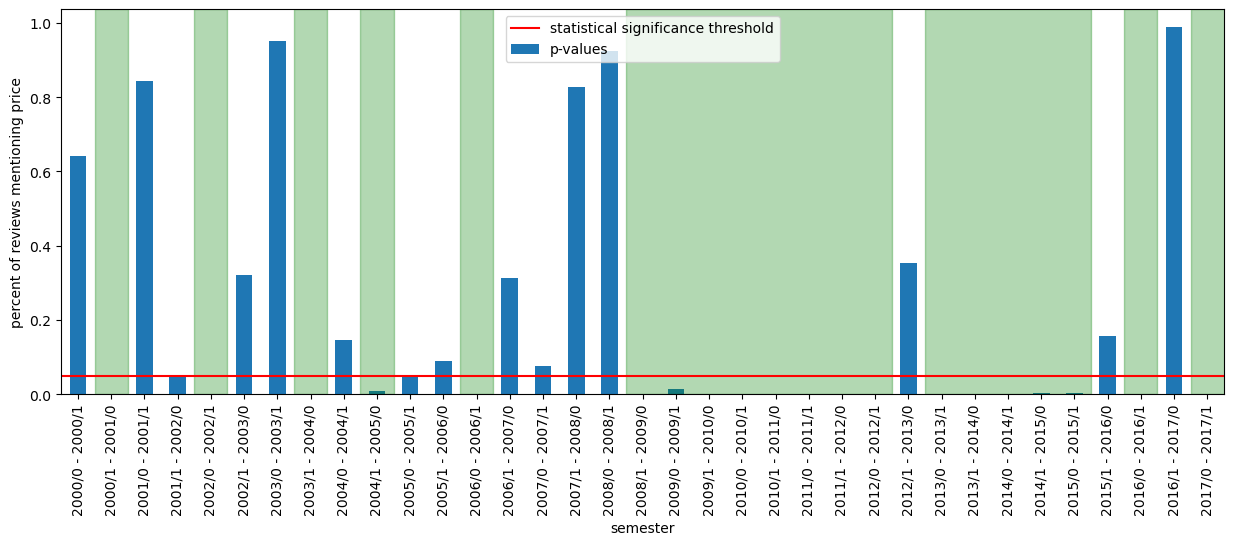

In [ ]:
#plot the ratios as bar plots
axes = p_values.plot.bar(x='name', y='p_value', figsize=(15,5), label='p-values')
plt.axhline(y=0.05, color='r', label='statistical significance threshold')

#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('semester')
plt.legend()

#Color the background in green if the change is statistically significant
color = 'green'
for i in range(len(changes_in_significance_positions)-1):
    if (i%2 == 1):
        plt.axvspan(changes_in_significance_positions[i] + 0.5, changes_in_significance_positions[i+1] + 0.5, alpha=0.3, color=color)

plt.show()

After the confirmation that the green intervals are at the right positions, we plot it on the graph with the semesters. <br>
Note that the change from the first to the second semester of 2000 is not significant, even though the effect size is large. <br>
This is due to the small sample size, which requires a bigger effect size to get a significant result.

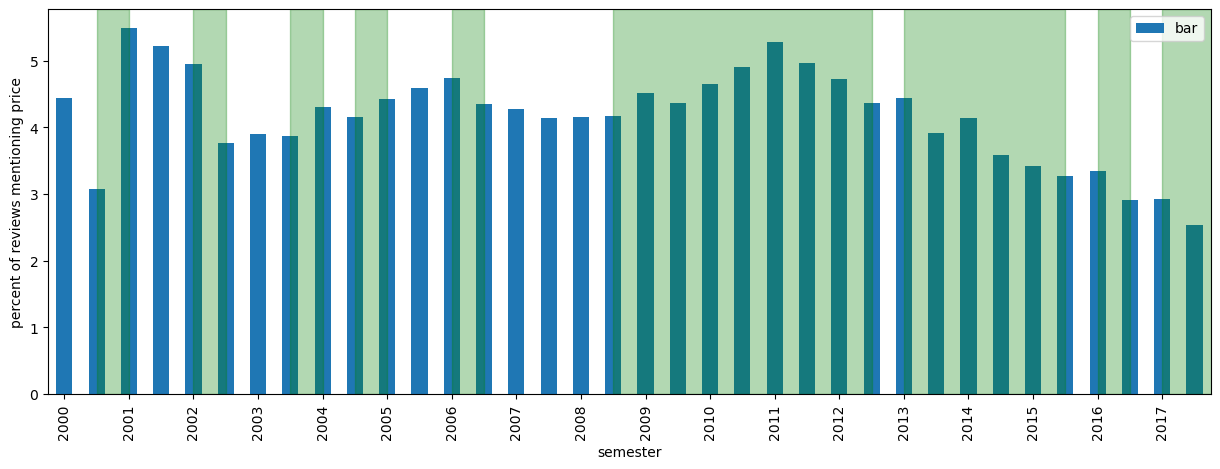

In [ ]:
#plot the ratios as bar plots
axes = semesterly_ratios.plot.bar(y='ratio', figsize=(15,5), label='bar')

#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('semester')
plt.legend()

#set ticks
labels_ = [item[0] for item in semesterly_ratios.index]
axes.set_xticklabels(labels_)

#Hide every second x tick
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 2 != 0:
        xticks[i].set_visible(False)

#Color the background in green if the change is statistically significant
color = 'green'
for i in range(len(changes_in_significance_positions)-1):
    if (i%2 == 1):
        plt.axvspan(changes_in_significance_positions[i] + 1, changes_in_significance_positions[i+1] + 1, alpha=0.3, color=color)

plt.show()

As a last visualization we plot it together with the interpolation on the illustration were every month is plotted. <br>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


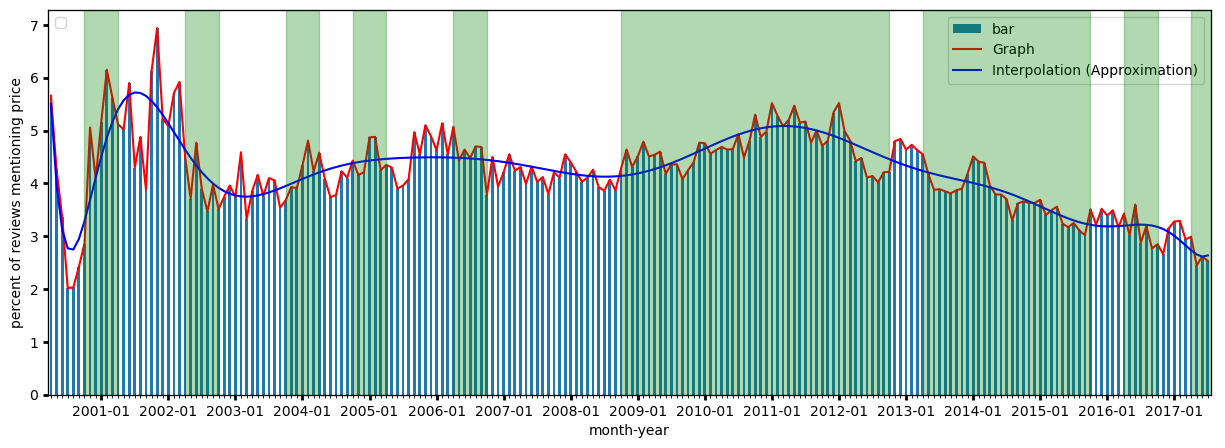

In [ ]:
#plot the ratios as bar plots
axes = df_ratio.plot.bar(x = 'month_year', y='ratio', figsize=(15,5), label='bar')
#Connect the bars with a graph
ax2 = axes.twinx()
df_ratio.plot.line(y='ratio', figsize=(15,5), color='red', ax=axes, label='Graph')
#Plot the interpolation of degree 14
ax3 = axes.twinx()
df_ratio.plot.line(y='interpolate', figsize=(15,5), color='blue', ax=axes, label='Interpolation (Approximation)')


#set labels
axes.set_ylabel('percent of reviews mentioning price')
axes.set_xlabel('month-year')
plt.legend()

#keep only the y-axis on the left
ax2.yaxis.set_ticks([])
ax3.yaxis.set_ticks([])

#set ticks
axes.set_xticks(major_ticks)
axes.set_xticks(minor_ticks, minor = True)
axes.tick_params(which = 'major', width=2)

#Color the background in green if the change is statistically significant
color = 'green'
for i in range(len(changes_in_significance_positions)-1):
    if (i%2 == 1):
        plt.axvspan(changes_in_significance_positions[i]*6 + 1*6, changes_in_significance_positions[i+1]*6 + 1*6, alpha=0.3, color=color)

plt.show()

We can observe that the after the economic crisis in 2008 the frequency of reviews mentioning price increases until mid-2011 with a statistically significant raise (over semesters). 